In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load files

In [2]:
# Load training and testing data
train_data_path = '/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_Data/'
test_data_path = '/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_40min_test/'

train_accel_data = pd.read_csv(train_data_path + 'Combined_accelerometer_100min.csv')
train_gyro_data = pd.read_csv(train_data_path + 'Combined_gyroscope_100min.csv')
train_linear_accel_data = pd.read_csv(train_data_path + 'Combined_linear_accelerometer_100min.csv')
train_magnetometer_data = pd.read_csv(train_data_path + 'Combined_magnetometer_100min.csv')

test_accel_data = pd.read_csv(test_data_path + 'Combined_accelerometer_40min.csv')
test_gyro_data = pd.read_csv(test_data_path + 'Combined_gyroscope_40min.csv')
test_linear_accel_data = pd.read_csv(test_data_path + 'Combined_linear_accelerometer_40min.csv')
test_magnetometer_data = pd.read_csv(test_data_path + 'Combined_magnetometer_40min.csv')

# Combine all data into one dataframe for training and testing
combined_train_data = pd.merge(train_accel_data, train_gyro_data, on=['time', 'label'], suffixes=('_acc', '_gyro'))
combined_train_data = pd.merge(combined_train_data, train_linear_accel_data, on=['time', 'label'], suffixes=('', '_lin_acc'))
combined_train_data = pd.merge(combined_train_data, train_magnetometer_data, on=['time', 'label'], suffixes=('', '_mag'))

combined_test_data = pd.merge(test_accel_data, test_gyro_data, on=['time', 'label'], suffixes=('_acc', '_gyro'))
combined_test_data = pd.merge(combined_test_data, test_linear_accel_data, on=['time', 'label'], suffixes=('', '_lin_acc'))
combined_test_data = pd.merge(combined_test_data, test_magnetometer_data, on=['time', 'label'], suffixes=('', '_mag'))


In [3]:
# Pre-processed sensor data
feature_columns = combined_train_data.columns.difference(['time', 'label'])
X_train_sensor = combined_train_data[feature_columns]
y_train = combined_train_data['label']

X_test_sensor = combined_test_data[feature_columns]
y_test = combined_test_data['label']

# Sensor + Temporal Data

In [4]:
# Sensor + Temporal Data
def add_temporal_features(df, lags, rolling_windows):
    for feature in df.columns:
        if feature not in ['time', 'label']:
            for lag in lags:
                df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
            for window in rolling_windows:
                df[f'{feature}_rolling_mean_{window}'] = df[feature].rolling(window=window).mean()
                df[f'{feature}_rolling_std_{window}'] = df[feature].rolling(window=window).std()
                df[f'{feature}_ewma'] = df[feature].ewm(span=7).mean()
    df.dropna(inplace=True)
    return df

lags = [5, 7, 10]
rolling_windows = [5, 7, 10]

combined_train_data_temporal = add_temporal_features(combined_train_data.copy(), lags, rolling_windows)
combined_test_data_temporal = add_temporal_features(combined_test_data.copy(), lags, rolling_windows)

feature_columns_temporal = combined_train_data_temporal.columns.difference(['time', 'label'])
X_train_temporal = combined_train_data_temporal[feature_columns_temporal]
y_train_temporal = combined_train_data_temporal['label']

X_test_temporal = combined_test_data_temporal[feature_columns_temporal]
y_test_temporal = combined_test_data_temporal['label']


# Sensor + Fourier Transformations

In [5]:
# Sensor + Fourier Transformations
def compute_fft_features(df, columns):
    fft_features = {}
    for col in columns:
        fft_vals = fft(df[col].values)
        fft_features[f'{col}_fft_real'] = np.real(fft_vals)
        fft_features[f'{col}_fft_imag'] = np.imag(fft_vals)
        fft_features[f'{col}_fft_abs'] = np.abs(fft_vals)
    return pd.DataFrame(fft_features, index=df.index)

fft_columns = combined_train_data.columns.difference(['time', 'label'])
fft_train_data = compute_fft_features(combined_train_data, fft_columns).dropna()
fft_test_data = compute_fft_features(combined_test_data, fft_columns).dropna()

feature_columns_fft = fft_train_data.columns
X_train_fft = fft_train_data
y_train_fft = combined_train_data['label']  # Same labels

X_test_fft = fft_test_data
y_test_fft = combined_test_data['label']  # Same labels

In [6]:

# Sensor + Temporal Features
X_train_sensor_temporal = pd.concat([X_train_sensor, X_train_temporal], axis=1).dropna()
X_test_sensor_temporal = pd.concat([X_test_sensor, X_test_temporal], axis=1).dropna()

y_train_sensor_temporal = y_train.loc[X_train_sensor_temporal.index]
y_test_sensor_temporal = y_test.loc[X_test_sensor_temporal.index]

# Sensor + Fourier Transformations
X_train_sensor_fft = pd.concat([X_train_sensor, X_train_fft], axis=1).dropna()
X_test_sensor_fft = pd.concat([X_test_sensor, X_test_fft], axis=1).dropna()

y_train_sensor_fft = y_train.loc[X_train_sensor_fft.index]
y_test_sensor_fft = y_test.loc[X_test_sensor_fft.index]

# Fourier + Temporal Features
X_train_fourier_temporal = pd.concat([X_train_temporal, X_train_fft], axis=1).dropna()
X_test_fourier_temporal = pd.concat([X_test_temporal, X_test_fft], axis=1).dropna()

y_train_fourier_temporal = y_train.loc[X_train_fourier_temporal.index]
y_test_fourier_temporal = y_test.loc[X_test_fourier_temporal.index]


# Sensor + Temporal + Fourier Features
X_train_all = pd.concat([X_train_sensor, X_train_temporal, X_train_fft], axis=1).dropna()
X_test_all = pd.concat([X_test_sensor, X_test_temporal, X_test_fft], axis=1).dropna()

y_train_all = y_train.loc[X_train_all.index]
y_test_all = y_test.loc[X_test_all.index]


# Train/Test

In [7]:
def plot_feature_importance(rf_model, feature_columns, title):
    feature_importances = rf_model.feature_importances_
    feature_names = feature_columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)

    plt.figure(figsize=(14, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

In [8]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, model_params, feature_columns, title):
    rf_model = RandomForestClassifier(**model_params)
    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['clapping', 'handshake', 'highfive', 'wave'])
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    
    # Plot feature importance
#     plot_feature_importance(rf_model, feature_columns, title)
    
    return rf_model

In [9]:
model_params = {
'n_estimators': 150, 
'max_depth': 17, 
'min_samples_split': 9, 
'min_samples_leaf': 1, 
'criterion': 'gini', 
'max_features': 'log2',
# 'n_estimators': 328, 
# 'max_depth': 17,
# 'min_samples_split': 7,
# 'min_samples_leaf': 1,
# 'criterion': 'gini',
# 'max_features': 'auto',
'random_state': 24
}

In [10]:
# Model 1: Pre-processed Sensor Data
print("Model 1: Pre-processed Sensor Data")
rf_model_sensor = train_and_evaluate_rf(X_train_sensor, y_train, X_test_sensor, y_test, model_params, feature_columns, "Feature Importance (Pre-processed Sensor Data)")

# Model 2: Temporal Features Only
print("Model 2: Temporal Features Only")
rf_model_temporal_only = train_and_evaluate_rf(X_train_temporal, y_train_temporal, X_test_temporal, y_test_temporal, model_params, feature_columns_temporal, "Feature Importance (Temporal Features Only)")

# Model 3: Fourier Transformation Only
print("Model 3: Fourier Transformation Only")
rf_model_fft_only = train_and_evaluate_rf(X_train_fft, y_train_fft, X_test_fft, y_test_fft, model_params, feature_columns_fft, "Feature Importance (Fourier Transformation Only)")

# Model 4: Sensor + Temporal Features
print("Model 4: Sensor + Temporal Features")
rf_model_sensor_temporal = train_and_evaluate_rf(X_train_sensor_temporal, y_train_sensor_temporal, X_test_sensor_temporal, y_test_sensor_temporal, model_params, X_train_sensor_temporal.columns, "Feature Importance (Sensor + Temporal Features)")

# Model 5: Sensor + Fourier Transformations
print("Model 5: Sensor + Fourier Transformations")
rf_model_sensor_fft = train_and_evaluate_rf(X_train_sensor_fft, y_train_sensor_fft, X_test_sensor_fft, y_test_sensor_fft, model_params, X_train_sensor_fft.columns, "Feature Importance (Sensor + Fourier Transformations)")

# Model 6: Sensor + Temporal + Fourier Features
print("Model 6: Sensor + Temporal + Fourier Features")
rf_model_all = train_and_evaluate_rf(X_train_all, y_train_all, X_test_all, y_test_all, model_params, X_train_all.columns, "Feature Importance (Sensor + Temporal + Fourier Features)")

# Model 7: Fourier + Temporal Features
print("Model 7: Fourier + Temporal Features")
rf_model_fourier_temporal = train_and_evaluate_rf(X_train_fourier_temporal, y_train_fourier_temporal, X_test_fourier_temporal, y_test_fourier_temporal, model_params, X_train_fourier_temporal.columns, "Feature Importance (Fourier + Temporal Features)")


Model 1: Pre-processed Sensor Data
Accuracy: 0.6409
Confusion Matrix:
[[ 909  281    0    0]
 [ 730  338   46   83]
 [  43   13 1020  118]
 [ 346   16   36  788]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.45      0.76      0.56      1190
   handshake       0.52      0.28      0.37      1197
    highfive       0.93      0.85      0.89      1194
        wave       0.80      0.66      0.72      1186

    accuracy                           0.64      4767
   macro avg       0.67      0.64      0.64      4767
weighted avg       0.67      0.64      0.64      4767

Model 2: Temporal Features Only
Accuracy: 0.7469
Confusion Matrix:
[[1173   13    4    0]
 [ 749  436    2    0]
 [   3    0 1167   24]
 [ 409    0    0  777]]
Classification Report:
              precision    recall  f1-score   support

    clapping       0.50      0.99      0.67      1190
   handshake       0.97      0.37      0.53      1187
    highfive       0.99      0.98

In [13]:
from statsmodels.tsa.stattools import acf, pacf

# Function to compute ACF and PACF and return the values
def compute_acf_pacf_values(series, lags=40):
    acf_vals = acf(series.dropna(), nlags=lags)
    pacf_vals = pacf(series.dropna(), nlags=lags)
    return acf_vals, pacf_vals

# Paths to your CSV files
file_paths = [
    '/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_Data/Combined_accelerometer_100min.csv',
    '/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_Data/Combined_gyroscope_100min.csv',
    '/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_Data/Combined_linear_accelerometer_100min.csv',
    '/Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_Data/Combined_magnetometer_100min.csv'
]


Processing /Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_Data/Combined_accelerometer_100min.csv
Processing /Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_Data/Combined_gyroscope_100min.csv
Processing /Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_Data/Combined_linear_accelerometer_100min.csv
Processing /Users/priyank/Desktop/ML4QS-project/Combined 80mins/Combined_100min_Data/Combined_magnetometer_100min.csv


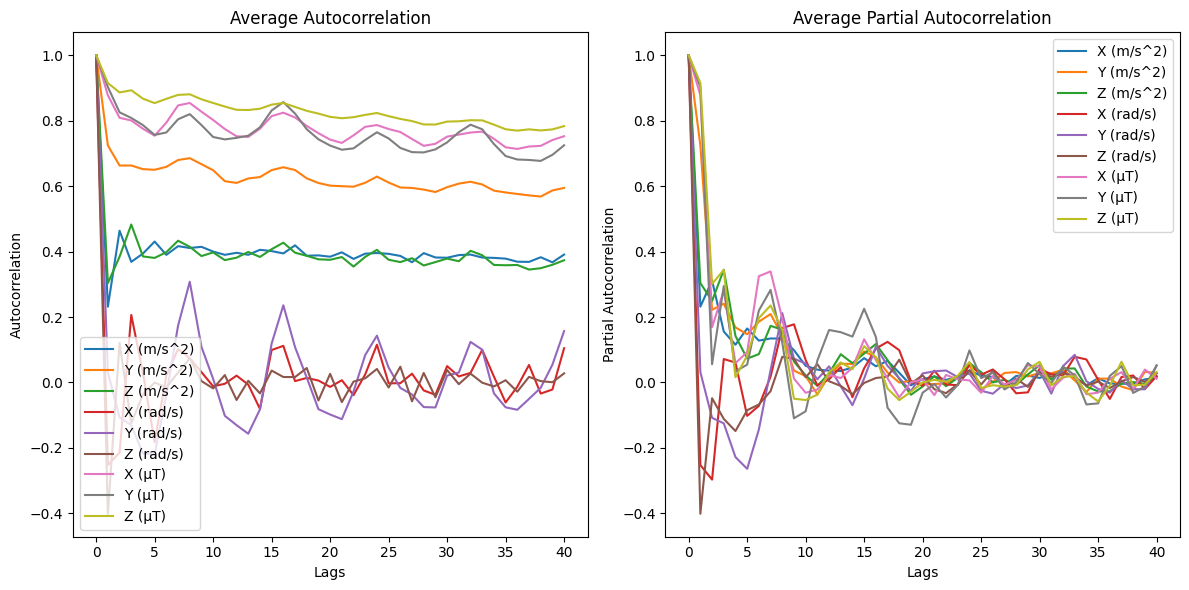

Processing complete.


In [14]:
# Initialize dictionaries to store the sums of ACF and PACF values for each column
acf_sums = {}
pacf_sums = {}
count = {}

# Load and process each file
for file_path in file_paths:
    df = pd.read_csv(file_path)
    print(f"Processing {file_path}")
    
    # Identify the columns to process (assuming all columns except 'time' and 'label' are relevant)
    columns_to_process = [col for col in df.columns if col not in ['time', 'label']]
    
    # Compute and sum ACF and PACF values for each relevant column
    for column in columns_to_process:
        acf_vals, pacf_vals = compute_acf_pacf_values(df[column])
        
        if column not in acf_sums:
            acf_sums[column] = np.zeros_like(acf_vals)
            pacf_sums[column] = np.zeros_like(pacf_vals)
            count[column] = 0
        
        acf_sums[column] += acf_vals
        pacf_sums[column] += pacf_vals
        count[column] += 1

# Compute the average ACF and PACF values
acf_avg = {col: acf_sums[col] / count[col] for col in acf_sums}
pacf_avg = {col: pacf_sums[col] / count[col] for col in pacf_sums}

# Function to plot average ACF and PACF
def plot_avg_acf_pacf(acf_avg, pacf_avg, lags=40):
    plt.figure(figsize=(12, 6))
    
    # Plot Average ACF
    plt.subplot(121)
    for col, acf_vals in acf_avg.items():
        plt.plot(range(lags+1), acf_vals, label=col)
    plt.title('Average Autocorrelation')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.legend()
    
    # Plot Average PACF
    plt.subplot(122)
    for col, pacf_vals in pacf_avg.items():
        plt.plot(range(lags+1), pacf_vals, label=col)
    plt.title('Average Partial Autocorrelation')
    plt.xlabel('Lags')
    plt.ylabel('Partial Autocorrelation')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the average ACF and PACF values
plot_avg_acf_pacf(acf_avg, pacf_avg)

print("Processing complete.")